In [2]:
import pennylane as qml
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
from sync import cost as cost_func
from sync import circuit, constant
import pennylane.numpy as np
import pennylane as qml
%load_ext autoreload
%autoreload 2


In [6]:
num_qubits = 3
num_layers = 5
num_blocks = num_qubits*(num_qubits-1)//2
active_blocks = np.ones(num_blocks * num_layers)
thetas = np.random.uniform(0, 2*np.pi, constant.num_params_on_active_blocks(active_blocks), requires_grad=True)

def u3cry(thetas):
    k, index_params = 0, 0
    for _ in range(num_layers):
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                if active_blocks[k] == 1:
                    qml.U3(thetas[index_params],thetas[index_params + 1],thetas[index_params + 2],i)
                    qml.U3(thetas[index_params + 3],thetas[index_params + 4],thetas[index_params + 5],j)
                    qml.CNOT([j, i])
                    index_params += 6
                k += 1

target = UnitaryGate(random_unitary(2**num_qubits))
def cost(thetas):
    matrix = qml.matrix(u3cry, wire_order=list(range(num_qubits)))(thetas)
    return cost_func.c_hst(matrix, target)

steps = 1000
costs = []
opt = qml.AdamOptimizer(stepsize = 0.01)
for n in range(steps):
    thetas, prev_cost = opt.step_and_cost(cost, thetas)
    if prev_cost < constant.error:
        print("Achieved error threshold at step", n)
        break
    costs.append(prev_cost)

# grad_fn = qml.grad(func = cost)
# for i in range(steps):
# 	gradient = grad_fn(thetas)
# 	thetas = thetas - 0.1 * gradient
# 	costs.append(cost(thetas))

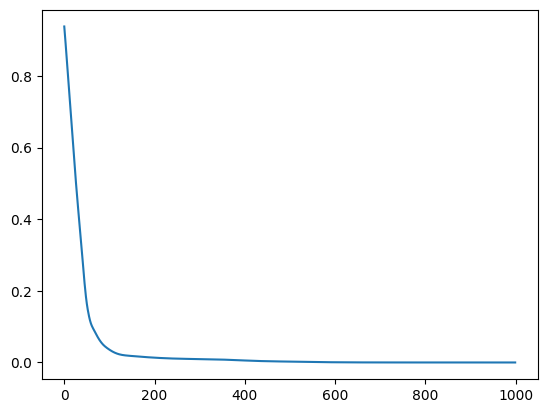

In [7]:
import matplotlib.pyplot as plt
plt.plot(costs)

In [8]:
costs[-1]

tensor(6.17410946e-05, requires_grad=True)